In [123]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

import os
import numpy as np
from os import listdir
from pathlib import Path
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
import h5py
import pydicom as dicom
import matplotlib.pyplot as plt
from dicompylercore import dicomparser, dvh, dvhcalc
from dicom_contour.contour import get_contour_file,get_roi_names, coord2pixels, cfile2pixels, plot2dcontour, slice_order, get_contour_dict, get_data,  create_image_mask_files
from preprocessing.get_plan_from_dicom import Plan, plot_DVH
from preprocessing.get_plan_from_dicom import plot_3d_img, IndexTracker
from dicom_contour.contour import get_ct_name_dict
from dicom_contour.dose import build_dose_volume
import pickle
from PIL import Image, ImageDraw

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [128]:
path = './dicom_data/ArcCheck/'

In [129]:
plan = Plan()
plan.get_plan_mask(path)

work on RS structure  test +++++++++++++++++++++++++++


{'1.3.6.1.4.1.9590.100.1.2.100358303112879286334752716123085442116': './dicom_data/ArcCheck/CT.1.3.6.1.4.1.9590.100.1.2.100358303112879286334752716123085442116.dcm',
 '1.3.6.1.4.1.9590.100.1.2.101084678913447379118551520162577816311': './dicom_data/ArcCheck/CT.1.3.6.1.4.1.9590.100.1.2.101084678913447379118551520162577816311.dcm',
 '1.3.6.1.4.1.9590.100.1.2.101891006312214783715775555910610702136': './dicom_data/ArcCheck/CT.1.3.6.1.4.1.9590.100.1.2.101891006312214783715775555910610702136.dcm',
 '1.3.6.1.4.1.9590.100.1.2.102289571812237866020712982344197638159': './dicom_data/ArcCheck/CT.1.3.6.1.4.1.9590.100.1.2.102289571812237866020712982344197638159.dcm',
 '1.3.6.1.4.1.9590.100.1.2.102576625812506922021139280983447358649': './dicom_data/ArcCheck/CT.1.3.6.1.4.1.9590.100.1.2.102576625812506922021139280983447358649.dcm',
 '1.3.6.1.4.1.9590.100.1.2.104736937911108485506816183492665744374': './dicom_data/ArcCheck/CT.1.3.6.1.4.1.9590.100.1.2.104736937911108485506816183492665744374.dcm',
 '1.

{'1.3.6.1.4.1.9590.100.1.2.100358303112879286334752716123085442116': './dicom_data/ArcCheck/CT.1.3.6.1.4.1.9590.100.1.2.100358303112879286334752716123085442116.dcm',
 '1.3.6.1.4.1.9590.100.1.2.101084678913447379118551520162577816311': './dicom_data/ArcCheck/CT.1.3.6.1.4.1.9590.100.1.2.101084678913447379118551520162577816311.dcm',
 '1.3.6.1.4.1.9590.100.1.2.101891006312214783715775555910610702136': './dicom_data/ArcCheck/CT.1.3.6.1.4.1.9590.100.1.2.101891006312214783715775555910610702136.dcm',
 '1.3.6.1.4.1.9590.100.1.2.102289571812237866020712982344197638159': './dicom_data/ArcCheck/CT.1.3.6.1.4.1.9590.100.1.2.102289571812237866020712982344197638159.dcm',
 '1.3.6.1.4.1.9590.100.1.2.102576625812506922021139280983447358649': './dicom_data/ArcCheck/CT.1.3.6.1.4.1.9590.100.1.2.102576625812506922021139280983447358649.dcm',
 '1.3.6.1.4.1.9590.100.1.2.104736937911108485506816183492665744374': './dicom_data/ArcCheck/CT.1.3.6.1.4.1.9590.100.1.2.104736937911108485506816183492665744374.dcm',
 '1.

{'1.3.6.1.4.1.9590.100.1.2.100358303112879286334752716123085442116': './dicom_data/ArcCheck/CT.1.3.6.1.4.1.9590.100.1.2.100358303112879286334752716123085442116.dcm',
 '1.3.6.1.4.1.9590.100.1.2.101084678913447379118551520162577816311': './dicom_data/ArcCheck/CT.1.3.6.1.4.1.9590.100.1.2.101084678913447379118551520162577816311.dcm',
 '1.3.6.1.4.1.9590.100.1.2.101891006312214783715775555910610702136': './dicom_data/ArcCheck/CT.1.3.6.1.4.1.9590.100.1.2.101891006312214783715775555910610702136.dcm',
 '1.3.6.1.4.1.9590.100.1.2.102289571812237866020712982344197638159': './dicom_data/ArcCheck/CT.1.3.6.1.4.1.9590.100.1.2.102289571812237866020712982344197638159.dcm',
 '1.3.6.1.4.1.9590.100.1.2.102576625812506922021139280983447358649': './dicom_data/ArcCheck/CT.1.3.6.1.4.1.9590.100.1.2.102576625812506922021139280983447358649.dcm',
 '1.3.6.1.4.1.9590.100.1.2.104736937911108485506816183492665744374': './dicom_data/ArcCheck/CT.1.3.6.1.4.1.9590.100.1.2.104736937911108485506816183492665744374.dcm',
 '1.

{'1.3.6.1.4.1.9590.100.1.2.100358303112879286334752716123085442116': './dicom_data/ArcCheck/CT.1.3.6.1.4.1.9590.100.1.2.100358303112879286334752716123085442116.dcm',
 '1.3.6.1.4.1.9590.100.1.2.101084678913447379118551520162577816311': './dicom_data/ArcCheck/CT.1.3.6.1.4.1.9590.100.1.2.101084678913447379118551520162577816311.dcm',
 '1.3.6.1.4.1.9590.100.1.2.101891006312214783715775555910610702136': './dicom_data/ArcCheck/CT.1.3.6.1.4.1.9590.100.1.2.101891006312214783715775555910610702136.dcm',
 '1.3.6.1.4.1.9590.100.1.2.102289571812237866020712982344197638159': './dicom_data/ArcCheck/CT.1.3.6.1.4.1.9590.100.1.2.102289571812237866020712982344197638159.dcm',
 '1.3.6.1.4.1.9590.100.1.2.102576625812506922021139280983447358649': './dicom_data/ArcCheck/CT.1.3.6.1.4.1.9590.100.1.2.102576625812506922021139280983447358649.dcm',
 '1.3.6.1.4.1.9590.100.1.2.104736937911108485506816183492665744374': './dicom_data/ArcCheck/CT.1.3.6.1.4.1.9590.100.1.2.104736937911108485506816183492665744374.dcm',
 '1.

{'1.3.6.1.4.1.9590.100.1.2.100358303112879286334752716123085442116': './dicom_data/ArcCheck/CT.1.3.6.1.4.1.9590.100.1.2.100358303112879286334752716123085442116.dcm',
 '1.3.6.1.4.1.9590.100.1.2.101084678913447379118551520162577816311': './dicom_data/ArcCheck/CT.1.3.6.1.4.1.9590.100.1.2.101084678913447379118551520162577816311.dcm',
 '1.3.6.1.4.1.9590.100.1.2.101891006312214783715775555910610702136': './dicom_data/ArcCheck/CT.1.3.6.1.4.1.9590.100.1.2.101891006312214783715775555910610702136.dcm',
 '1.3.6.1.4.1.9590.100.1.2.102289571812237866020712982344197638159': './dicom_data/ArcCheck/CT.1.3.6.1.4.1.9590.100.1.2.102289571812237866020712982344197638159.dcm',
 '1.3.6.1.4.1.9590.100.1.2.102576625812506922021139280983447358649': './dicom_data/ArcCheck/CT.1.3.6.1.4.1.9590.100.1.2.102576625812506922021139280983447358649.dcm',
 '1.3.6.1.4.1.9590.100.1.2.104736937911108485506816183492665744374': './dicom_data/ArcCheck/CT.1.3.6.1.4.1.9590.100.1.2.104736937911108485506816183492665744374.dcm',
 '1.

{'1.3.6.1.4.1.9590.100.1.2.100358303112879286334752716123085442116': './dicom_data/ArcCheck/CT.1.3.6.1.4.1.9590.100.1.2.100358303112879286334752716123085442116.dcm',
 '1.3.6.1.4.1.9590.100.1.2.101084678913447379118551520162577816311': './dicom_data/ArcCheck/CT.1.3.6.1.4.1.9590.100.1.2.101084678913447379118551520162577816311.dcm',
 '1.3.6.1.4.1.9590.100.1.2.101891006312214783715775555910610702136': './dicom_data/ArcCheck/CT.1.3.6.1.4.1.9590.100.1.2.101891006312214783715775555910610702136.dcm',
 '1.3.6.1.4.1.9590.100.1.2.102289571812237866020712982344197638159': './dicom_data/ArcCheck/CT.1.3.6.1.4.1.9590.100.1.2.102289571812237866020712982344197638159.dcm',
 '1.3.6.1.4.1.9590.100.1.2.102576625812506922021139280983447358649': './dicom_data/ArcCheck/CT.1.3.6.1.4.1.9590.100.1.2.102576625812506922021139280983447358649.dcm',
 '1.3.6.1.4.1.9590.100.1.2.104736937911108485506816183492665744374': './dicom_data/ArcCheck/CT.1.3.6.1.4.1.9590.100.1.2.104736937911108485506816183492665744374.dcm',
 '1.

{'1.3.6.1.4.1.9590.100.1.2.100358303112879286334752716123085442116': './dicom_data/ArcCheck/CT.1.3.6.1.4.1.9590.100.1.2.100358303112879286334752716123085442116.dcm',
 '1.3.6.1.4.1.9590.100.1.2.101084678913447379118551520162577816311': './dicom_data/ArcCheck/CT.1.3.6.1.4.1.9590.100.1.2.101084678913447379118551520162577816311.dcm',
 '1.3.6.1.4.1.9590.100.1.2.101891006312214783715775555910610702136': './dicom_data/ArcCheck/CT.1.3.6.1.4.1.9590.100.1.2.101891006312214783715775555910610702136.dcm',
 '1.3.6.1.4.1.9590.100.1.2.102289571812237866020712982344197638159': './dicom_data/ArcCheck/CT.1.3.6.1.4.1.9590.100.1.2.102289571812237866020712982344197638159.dcm',
 '1.3.6.1.4.1.9590.100.1.2.102576625812506922021139280983447358649': './dicom_data/ArcCheck/CT.1.3.6.1.4.1.9590.100.1.2.102576625812506922021139280983447358649.dcm',
 '1.3.6.1.4.1.9590.100.1.2.104736937911108485506816183492665744374': './dicom_data/ArcCheck/CT.1.3.6.1.4.1.9590.100.1.2.104736937911108485506816183492665744374.dcm',
 '1.

{'1.3.6.1.4.1.9590.100.1.2.100358303112879286334752716123085442116': './dicom_data/ArcCheck/CT.1.3.6.1.4.1.9590.100.1.2.100358303112879286334752716123085442116.dcm',
 '1.3.6.1.4.1.9590.100.1.2.101084678913447379118551520162577816311': './dicom_data/ArcCheck/CT.1.3.6.1.4.1.9590.100.1.2.101084678913447379118551520162577816311.dcm',
 '1.3.6.1.4.1.9590.100.1.2.101891006312214783715775555910610702136': './dicom_data/ArcCheck/CT.1.3.6.1.4.1.9590.100.1.2.101891006312214783715775555910610702136.dcm',
 '1.3.6.1.4.1.9590.100.1.2.102289571812237866020712982344197638159': './dicom_data/ArcCheck/CT.1.3.6.1.4.1.9590.100.1.2.102289571812237866020712982344197638159.dcm',
 '1.3.6.1.4.1.9590.100.1.2.102576625812506922021139280983447358649': './dicom_data/ArcCheck/CT.1.3.6.1.4.1.9590.100.1.2.102576625812506922021139280983447358649.dcm',
 '1.3.6.1.4.1.9590.100.1.2.104736937911108485506816183492665744374': './dicom_data/ArcCheck/CT.1.3.6.1.4.1.9590.100.1.2.104736937911108485506816183492665744374.dcm',
 '1.

{'1.3.6.1.4.1.9590.100.1.2.100358303112879286334752716123085442116': './dicom_data/ArcCheck/CT.1.3.6.1.4.1.9590.100.1.2.100358303112879286334752716123085442116.dcm',
 '1.3.6.1.4.1.9590.100.1.2.101084678913447379118551520162577816311': './dicom_data/ArcCheck/CT.1.3.6.1.4.1.9590.100.1.2.101084678913447379118551520162577816311.dcm',
 '1.3.6.1.4.1.9590.100.1.2.101891006312214783715775555910610702136': './dicom_data/ArcCheck/CT.1.3.6.1.4.1.9590.100.1.2.101891006312214783715775555910610702136.dcm',
 '1.3.6.1.4.1.9590.100.1.2.102289571812237866020712982344197638159': './dicom_data/ArcCheck/CT.1.3.6.1.4.1.9590.100.1.2.102289571812237866020712982344197638159.dcm',
 '1.3.6.1.4.1.9590.100.1.2.102576625812506922021139280983447358649': './dicom_data/ArcCheck/CT.1.3.6.1.4.1.9590.100.1.2.102576625812506922021139280983447358649.dcm',
 '1.3.6.1.4.1.9590.100.1.2.104736937911108485506816183492665744374': './dicom_data/ArcCheck/CT.1.3.6.1.4.1.9590.100.1.2.104736937911108485506816183492665744374.dcm',
 '1.

{'1.3.6.1.4.1.9590.100.1.2.100358303112879286334752716123085442116': './dicom_data/ArcCheck/CT.1.3.6.1.4.1.9590.100.1.2.100358303112879286334752716123085442116.dcm',
 '1.3.6.1.4.1.9590.100.1.2.101084678913447379118551520162577816311': './dicom_data/ArcCheck/CT.1.3.6.1.4.1.9590.100.1.2.101084678913447379118551520162577816311.dcm',
 '1.3.6.1.4.1.9590.100.1.2.101891006312214783715775555910610702136': './dicom_data/ArcCheck/CT.1.3.6.1.4.1.9590.100.1.2.101891006312214783715775555910610702136.dcm',
 '1.3.6.1.4.1.9590.100.1.2.102289571812237866020712982344197638159': './dicom_data/ArcCheck/CT.1.3.6.1.4.1.9590.100.1.2.102289571812237866020712982344197638159.dcm',
 '1.3.6.1.4.1.9590.100.1.2.102576625812506922021139280983447358649': './dicom_data/ArcCheck/CT.1.3.6.1.4.1.9590.100.1.2.102576625812506922021139280983447358649.dcm',
 '1.3.6.1.4.1.9590.100.1.2.104736937911108485506816183492665744374': './dicom_data/ArcCheck/CT.1.3.6.1.4.1.9590.100.1.2.104736937911108485506816183492665744374.dcm',
 '1.

{'1.3.6.1.4.1.9590.100.1.2.100358303112879286334752716123085442116': './dicom_data/ArcCheck/CT.1.3.6.1.4.1.9590.100.1.2.100358303112879286334752716123085442116.dcm',
 '1.3.6.1.4.1.9590.100.1.2.101084678913447379118551520162577816311': './dicom_data/ArcCheck/CT.1.3.6.1.4.1.9590.100.1.2.101084678913447379118551520162577816311.dcm',
 '1.3.6.1.4.1.9590.100.1.2.101891006312214783715775555910610702136': './dicom_data/ArcCheck/CT.1.3.6.1.4.1.9590.100.1.2.101891006312214783715775555910610702136.dcm',
 '1.3.6.1.4.1.9590.100.1.2.102289571812237866020712982344197638159': './dicom_data/ArcCheck/CT.1.3.6.1.4.1.9590.100.1.2.102289571812237866020712982344197638159.dcm',
 '1.3.6.1.4.1.9590.100.1.2.102576625812506922021139280983447358649': './dicom_data/ArcCheck/CT.1.3.6.1.4.1.9590.100.1.2.102576625812506922021139280983447358649.dcm',
 '1.3.6.1.4.1.9590.100.1.2.104736937911108485506816183492665744374': './dicom_data/ArcCheck/CT.1.3.6.1.4.1.9590.100.1.2.104736937911108485506816183492665744374.dcm',
 '1.

defaultdict(None,
            {'BODY': {'mask': array([[[False, False, False, ..., False, False, False],
                      [False, False, False, ..., False, False, False],
                      [False, False, False, ..., False, False, False],
                      ...,
                      [False, False, False, ..., False, False, False],
                      [False, False, False, ..., False, False, False],
                      [False, False, False, ..., False, False, False]],
              
                     [[False, False, False, ..., False, False, False],
                      [False, False, False, ..., False, False, False],
                      [False, False, False, ..., False, False, False],
                      ...,
                      [False, False, False, ..., False, False, False],
                      [False, False, False, ..., False, False, False],
                      [False, False, False, ..., False, False, False]],
              
                     [[False

In [126]:
standard_name = ['PTV_Ribs', 'PTV_VExP', 'PTV_SpCord', 'PTV_LN', 'PTV_Spleen', 'PTV_Liver', 'BODY', 'Lungs', 'Heart', 'Esophagus', 'GI_Upper', 'Rectum', 'Breasts']
plan.rename()

PTV_Ribs <--------> PTV_Ribs
PTV_VExP <--------> PTV_VExP
PTV_SpCord <--------> PTV_SpCord
PTV_LN <--------> PTV_LN
PTV_Spleen <--------> PTV_Spleen
PTV_Liver <--------> PTV_Liver
BODY <--------> BODY
Lungs <--------> Lungs
Heart <--------> Heart
Esophagus <--------> Esophagus
GI_Upper <--------> GI_Upper
Rectum <--------> Rectum


In [106]:
plan.structures.keys()

dict_keys(['BODY', 'Rods', 'PTV_High', 'Ring_1', 'organ1'])

In [17]:
with open("plan.pickle", "wb") as file_:
    pickle.dump(plan, file_, -1)

In [3]:
plan = pickle.load(open("plan.pickle", "rb", -1))

<IPython.core.display.Javascript object>


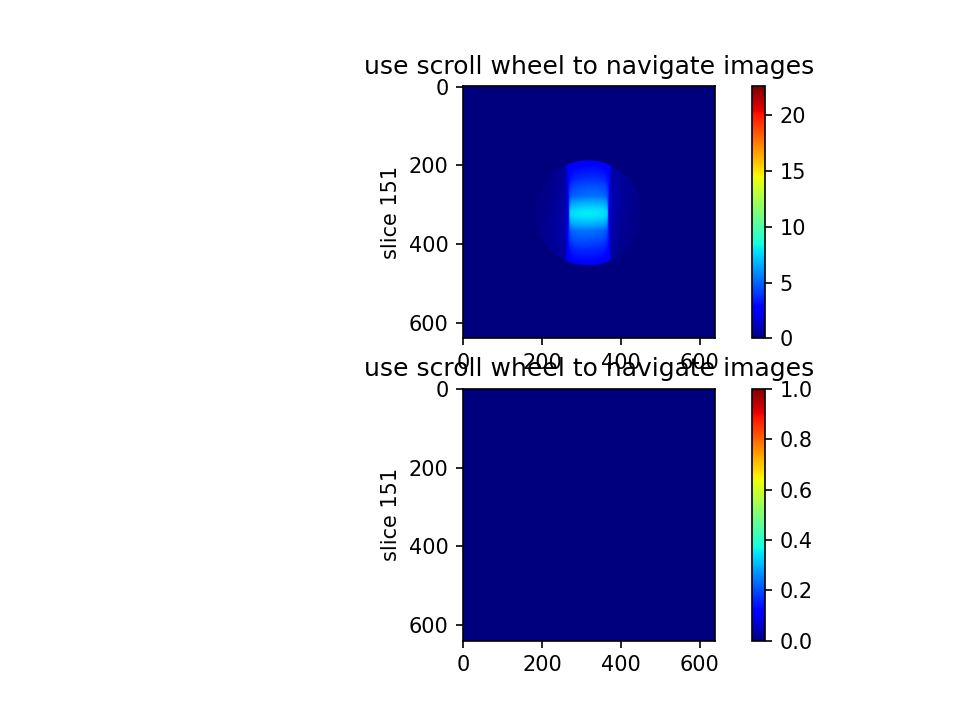

In [130]:
organ = 'Ring_1'
fig, (ax1, ax2)= plt.subplots(2, 1)
max_img = np.max(plan.img_volume.flatten())
max_dose = np.max(plan.dose_volume.flatten())
#tracker1 = IndexTracker(ax1, plan.img_volume, fig,0,max_img)
#fig.canvas.mpl_connect('scroll_event', tracker1.onscroll)
tracker1 = IndexTracker(ax1, plan.dose_volume, fig,0,max_dose)
fig.canvas.mpl_connect('scroll_event', tracker1.onscroll)
tracker2 = IndexTracker(ax2, plan.structures[organ]['mask'], fig,0,1)
fig.canvas.mpl_connect('scroll_event', tracker2.onscroll)
#tracker4 = IndexTracker(ax4, plan.structures[organ]['contour'], fig,0,1)
#fig.canvas.mpl_connect('scroll_event', tracker4.onscroll)
plt.show()



In [117]:
dose_test = build_dose_volume(path)
np.shape(dose_test.Array_Volume)

(160, 256, 256)

<IPython.core.display.Javascript object>


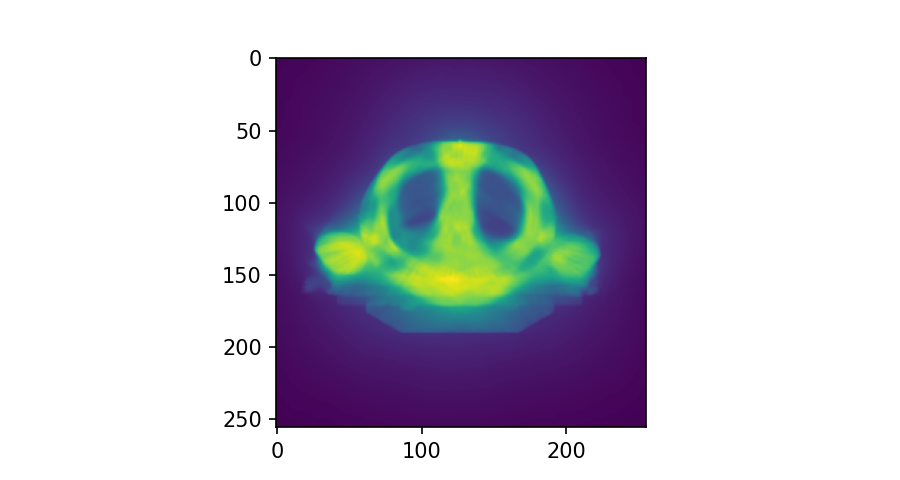

In [118]:
fig = plt.figure(figsize=(6, 3.2))
plt.imshow(dose_test.Array_Volume[80,:,:])
plt.show()

PTV_High
True mean organ dose is:  17.951583950550003
True max organ dose is:  20.943046100299313
Ring_1
True mean organ dose is:  16.246219695862244
True max organ dose is:  21.091811849664264


<IPython.core.display.Javascript object>


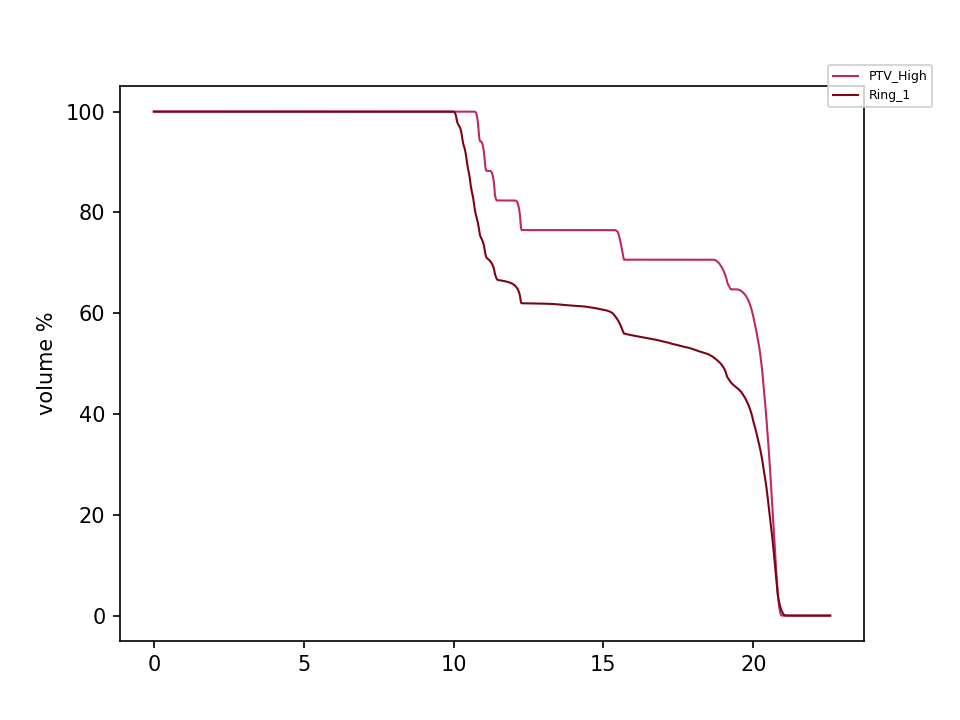

(defaultdict(None,
             {'PTV_High': array([1., 1., 1., ..., 0., 0., 0.]),
              'Ring_1': array([1., 1., 1., ..., 0., 0., 0.])}),
 {'PTV_High': 17.951583950550003, 'Ring_1': 16.246219695862244},
 {'PTV_High': 20.943046100299313, 'Ring_1': 21.091811849664264},
 {'PTV_High': 10.84811451077106, 'Ring_1': 10.283696482114916},
 {'PTV_High': 20.80444853626541, 'Ring_1': 20.80444853626541})

In [109]:
standard_list = ['PTV_Ribs', 'PTV_VExP', 'PTV_SpCord', 'PTV_LN', 'PTV_Spleen', 'PTV_Liver', 'BODY', 'Lungs']
standard_list = ['PTV_High', 'Ring_1']
plot_DVH(plan, standard_list)

In [111]:
np.shape(plan.img_volume)

(251, 640, 640)

In [48]:
contour_arr_orignal = plan.structures['Ring_1']['contour'][107,:,:]

def fill_contour_new(contour_arr_orignal):
    # get initial pixel positions
    contour_arr = contour_arr_orignal.copy()
    pixel_positions = np.array([(i, j) for i, j in zip(np.where(contour_arr)[0], np.where(contour_arr)[1])])
    width = np.shape(contour_arr)[0]
    height = np.shape(contour_arr)[1] 
    img = Image.new('L', (width, height), 0)
    ImageDraw.Draw(img).polygon(polygon, outline=1, fill=1)
    contour_arr = numpy.array(img)
    
    return contour_arr

contour_arr = fill_contour_new(contour_arr_orignal)
plt.imshow(contour_arr)

NameError: name 'polygon' is not defined

In [43]:
contour_arr_orignal = plan.structures['Ring_1']['contour']

In [54]:
x=np.array([1,2,3])
y=np.array([4,5,6])
z = np.array([7])
xx,yy, zz = np.meshgrid(x,y,z)

In [65]:
dose_plane = dose_vol.interpolating_function(test)

In [46]:
contour_arr_orignal = plan.structures['Ring_1']['contour'][107,:,:]

In [47]:
np.shape(contour_arr_orignal)

(640, 640)

In [67]:
np.shape(dose_plane)

(3, 3)

In [31]:
test  =[[1,1,1],[2,2,2]]

In [33]:
np.shape(test)[0]

2